# Dimensionality reduction on trial features

In [239]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [241]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

## Parameters

In [3]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0.0
optimal_k = 4

save_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [4]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get sequences per trial

In [ ]:
# # Load trial clsuters
# results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
# filename = str(results_path + 'cluster_per_trial_no_timing03-19-2025')
# trial_clusters = pd.read_parquet(filename, engine='pyarrow')

In [92]:
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
filename = str(results_path + 'epoch_sequences_10_03-11-2025')
all_sequences = pickle.load(open(filename, 'rb'))
all_sequences['session'] = all_sequences['sample'].str[:36]

In [93]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

## Separate states per variable (one-hot encoding)

In [21]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

In [ ]:
final_matrix = binarized.copy()

([<matplotlib.axis.XTick at 0x7fb4a3050c70>,
 [Text(0, 0, '0'),
  Text(160, 0, '160'),
  Text(320, 0, '320'),
  Text(480, 0, '480')])

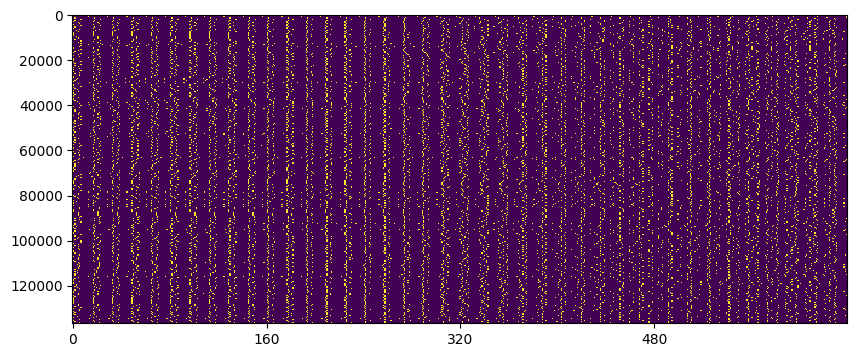

In [11]:
plt.figure(figsize=(10, 4))
plt.imshow(final_matrix, aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

## Average per session

In [34]:
session_syllables = pd.DataFrame(final_matrix)
session_syllables['session'] = design_df['session'].copy()
session_syllables = session_syllables.groupby('session')[np.arange(0, 640, 1)].mean()

([<matplotlib.axis.XTick at 0x7fb24a228370>,
 [Text(0, 0, '0'),
  Text(160, 0, '160'),
  Text(320, 0, '320'),
  Text(480, 0, '480')])

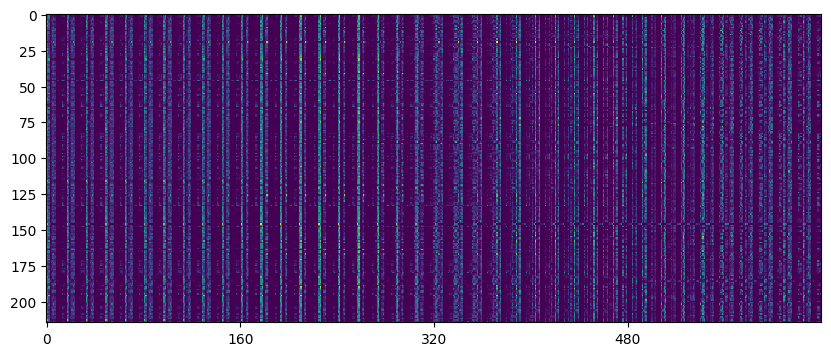

In [ ]:
plt.figure(figsize=(10, 4))
plt.imshow(np.array(session_syllables), aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

In [37]:
final_matrix = np.array(session_syllables)

In [43]:
def split_sessions(trial_clusters, n_parts):

    rng = np.random.default_rng() 

    trial_clusters['session_part'] = trial_clusters['response'] * np.nan

    for s, session in enumerate(trial_clusters.session.unique()):
        session_df = trial_clusters.loc[trial_clusters['session']==session]
        n_trials = len(session_df)
        # Create shuffled labels for parts
        parts = np.tile(np.arange(n_parts), int(np.ceil(n_trials / n_parts)))[:n_trials]
        rng.shuffle(parts)  # Shuffle to randomize assignment
        # els.extend(parts)
        trial_clusters.loc[trial_clusters['session']==session, 'session_part'] = parts

    # Assign to new column
    trial_clusters['session_part'] = trial_clusters['session_part'].astype(str)
    trial_clusters = trial_clusters.rename(columns={"sample": "old_sample"})
    trial_clusters['sample'] = trial_clusters[['session', 'session_part']].agg(' '.join, axis=1)
    
    split_session_df = trial_clusters.copy()
    
    return split_session_df


def get_fraction_vectors(trial_clusters, target_length):

    all_sequences = pd.DataFrame(columns=['sample', 'mouse_name', 'session', 'trial_type', 'cluster', 'bin'])
    for s, sample in enumerate(trial_clusters['sample'].unique()):

        # Get session data and order trials
        session_data = trial_clusters.loc[trial_clusters['sample']==sample]
        session_data = session_data[['sample', 'mouse_name', 'session', 'trial_id', 'trial_type', 'cluster']].drop_duplicates()
        session_data['trial_id'] = session_data['trial_id'].astype(float)
        session_data = session_data.sort_values(by=['trial_id'])

        # Bin 
        n_trials = len(session_data)
        # Assign bin index: split into 10 parts
        bin_indices = pd.qcut(np.arange(n_trials), q=target_length, labels=False)
        session_data['bin'] = bin_indices
        
        all_sequences = pd.concat([all_sequences, session_data[['sample', 'mouse_name', 'session', 
                                                                'trial_type', 'cluster', 'bin']]], ignore_index=True)

    fractions = all_sequences.groupby(['sample', 'mouse_name', 'session',
                                    'bin'])['cluster'].value_counts(normalize=True).rename('fraction').reset_index().sort_values(by=['bin', 'cluster'])
    design_df = fractions.pivot(index=['mouse_name', 'sample', 'session'], columns=['bin', 'cluster'], values='fraction').reset_index().fillna(0)

    return design_df
    
    
def prepare_design_mat(design_df):
    decoded_var = 'mouse_name'
    var = 'fact_var'

    mat = pd.DataFrame(design_df)
    mat['fact_var'] = pd.factorize(design_df[decoded_var])[0]
    mat[decoded_var] = design_df[decoded_var]

    use_labels = mat['fact_var'].unique()

    session_mouse_names = mat.loc[mat['fact_var'].isin(use_labels), decoded_var]
    session_names = pd.factorize(design_df['session'])[0]
    named_labels = mat.loc[mat['fact_var'].isin(use_labels), decoded_var].drop_duplicates()
    use_mat_pre = mat.loc[mat['fact_var'].isin(use_labels)]
    array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))
    use_mat = pd.DataFrame(array_mat[:, :-1])
    use_mat[var] = use_mat_pre[var]
    
    return use_mat, named_labels, session_mouse_names, session_names 

In [129]:
def split_sessions(all_sequences, n_parts):

    rng = np.random.default_rng() 

    all_sequences['session_part'] = np.zeros(len(all_sequences))

    for s, session in enumerate(all_sequences.session.unique()):
        session_df = all_sequences.loc[all_sequences['session']==session]
        n_trials = len(session_df)
        # Create shuffled labels for parts
        parts = np.tile(np.arange(n_parts), int(np.ceil(n_trials / n_parts)))[:n_trials]
        rng.shuffle(parts)  # Shuffle to randomize assignment
        # els.extend(parts)
        all_sequences.loc[all_sequences['session']==session, 'session_part'] = parts

    # Assign to new column
    all_sequences['session_part'] = all_sequences['session_part'].astype(str)
    # all_sequences = all_sequences.rename(columns={"sample": "trial_id"})
    all_sequences['session_part_sample'] = all_sequences[['session', 'session_part']].agg(' '.join, axis=1)
    
    split_session_df = all_sequences.copy()
    
    return split_session_df


def binarize(design_df):

    epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']
    sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

    use_states = int(max(np.unique(use_sequences)))+1
    timesteps = np.shape(use_sequences)[1]
    binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

    for t in range(timesteps):
        label_binarizer = LabelBinarizer()
        label_binarizer.fit(range(use_states))
        encoded_arr = label_binarizer.transform(use_sequences[:, t])
        binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

    return binarized

def prepare_design_mat(design_df):
    decoded_var = 'mouse_name'
    var = 'fact_var'

    mat = pd.DataFrame(design_df)
    mat['fact_var'] = pd.factorize(design_df[decoded_var])[0]
    mat[decoded_var] = design_df[decoded_var]

    use_labels = mat['fact_var'].unique()

    session_mouse_names = mat.loc[mat['fact_var'].isin(use_labels), decoded_var]
    session_names = pd.factorize(design_df['session'])[0]
    named_labels = mat.loc[mat['fact_var'].isin(use_labels), decoded_var].drop_duplicates()
    use_mat_pre = mat.loc[mat['fact_var'].isin(use_labels)]
    # array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))
    array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session']))

    use_mat = pd.DataFrame(array_mat[:, :-1])
    use_mat[var] = use_mat_pre[var]
    
    return use_mat, named_labels, session_mouse_names, session_names 

In [172]:
n_parts = 2
repeats = 200

## Repeated samplings

In [173]:
samplings_df = pd.DataFrame(columns=['repeat', 'matrix', 'distance_matrix'], index=range(repeats))

for r in range(repeats):
    print('Repeat %d of %d' % (r+1, repeats))  
        
    # Split data anew
    split_session_df = split_sessions(design_df, 2)
    split_session_df = split_session_df.sort_values(by='mouse_name')
    split_session_df = split_session_df.loc[split_session_df['session_part']=='0.0']  # Use only one sample per session each time
    use_samples = split_session_df['sample']
    use_sequences = all_sequences.loc[all_sequences['sample'].isin(np.array(use_samples))]
    use_df = use_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
    var_names = use_df.keys()[-4:]
        
    use_binarized = binarize(use_df)
    session_syllables = pd.DataFrame(use_binarized)
    session_syllables['session'] = use_df['session'].copy()
    session_syllables['mouse_name'] = use_df['mouse_name'].copy()
    session_syllables = session_syllables.groupby(['session', 'mouse_name'])[np.arange(0, 640, 1)].mean().reset_index()
    session_syllables = session_syllables.sort_values(by='mouse_name')

    use_mat, named_labels, session_mouse_names, session_names = prepare_design_mat(session_syllables)
    pairwise_matrix = pairwise_distances(use_mat.drop(columns='fact_var'), metric='cosine')

    # Save results
    samplings_df.loc[r, 'repeat'] = r
    samplings_df.loc[r, 'matrix'] = np.array(use_mat.drop(columns='fact_var'))
    samplings_df.loc[r, 'distance_matrix'] = pairwise_matrix
    

Repeat 1 of 200
Repeat 2 of 200
Repeat 3 of 200
Repeat 4 of 200
Repeat 5 of 200
Repeat 6 of 200
Repeat 7 of 200
Repeat 8 of 200
Repeat 9 of 200
Repeat 10 of 200
Repeat 11 of 200
Repeat 12 of 200
Repeat 13 of 200
Repeat 14 of 200
Repeat 15 of 200
Repeat 16 of 200
Repeat 17 of 200
Repeat 18 of 200
Repeat 19 of 200
Repeat 20 of 200
Repeat 21 of 200
Repeat 22 of 200
Repeat 23 of 200
Repeat 24 of 200
Repeat 25 of 200
Repeat 26 of 200
Repeat 27 of 200
Repeat 28 of 200
Repeat 29 of 200
Repeat 30 of 200
Repeat 31 of 200
Repeat 32 of 200
Repeat 33 of 200
Repeat 34 of 200
Repeat 35 of 200
Repeat 36 of 200
Repeat 37 of 200
Repeat 38 of 200
Repeat 39 of 200
Repeat 40 of 200
Repeat 41 of 200
Repeat 42 of 200
Repeat 43 of 200
Repeat 44 of 200
Repeat 45 of 200
Repeat 46 of 200
Repeat 47 of 200
Repeat 48 of 200
Repeat 49 of 200
Repeat 50 of 200
Repeat 51 of 200
Repeat 52 of 200
Repeat 53 of 200
Repeat 54 of 200
Repeat 55 of 200
Repeat 56 of 200
Repeat 57 of 200
Repeat 58 of 200
Repeat 59 of 200
Repeat

(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 [Text(0, -50.0, '−50'),
  Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250')])

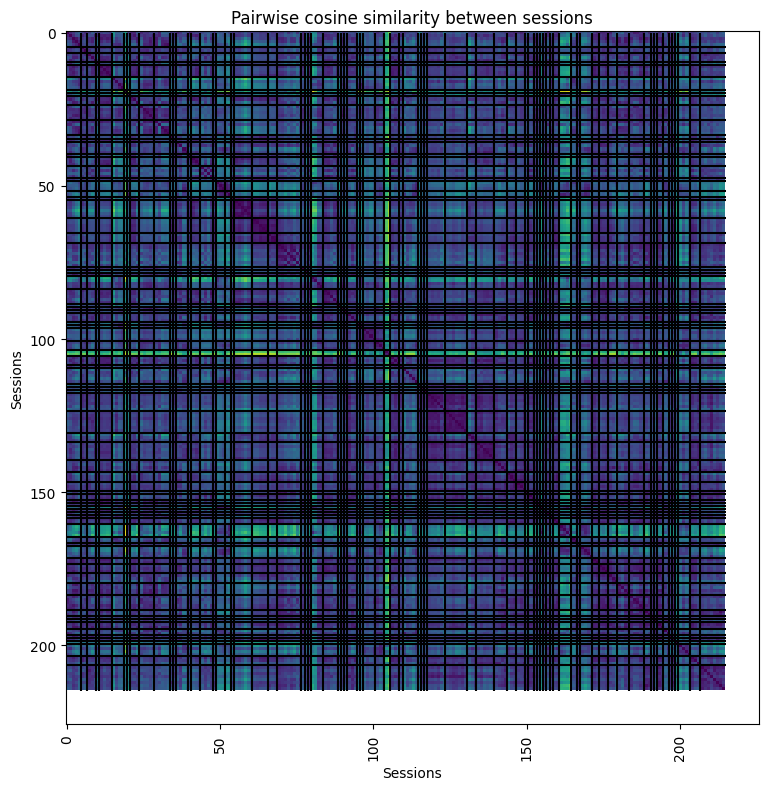

In [171]:
# fig, ax = plt.subplots(figsize=[20, 15])
fig, ax = plt.subplots(figsize=[10, 9])
plt.imshow(np.mean(list(samplings_df['distance_matrix']), axis=0))
plt.xlabel('Sessions')
plt.ylabel('Sessions')
plt.title('Pairwise cosine similarity between sessions')

mouse_numbers = pd.factorize(session_syllables['mouse_name'])[0]
# mouse_numbers = session_mouse_names
for m_lines in np.where(np.diff(mouse_numbers)==1):
    plt.vlines(m_lines+.5, 0, len(mouse_numbers), color='k')
    plt.hlines(m_lines+.5, 0, len(mouse_numbers), color='k')
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)

# plt.xlim([np.shape(samplings_df['distance_matrix'])[0], 0])
# plt.ylim([0, np.shape(samplings_df['distance_matrix'])[0]])

## Cluster each repeat and build consensus matrix

In [299]:
k = 4
samplings_df['clusters'] = samplings_df['repeat'] * np.nan
n_samples, _ = pairwise_matrix.shape
consensus_matrix = np.zeros((n_samples, n_samples))

for r in range(repeats):
    pairwise_matrix = list(samplings_df.loc[samplings_df['repeat']==r, 'distance_matrix'])[0]
    linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
    # _ = plot_dendrogram(pairwise_matrix, title="Hierarchical Clustering")
    # plt.show()
    
    clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')
    samplings_df['clusters'][r] = clusters 

    for i in range(n_samples):
        for j in range(i, n_samples):
            if clusters[i] == clusters[j]:
                consensus_matrix[i, j] += 1
                if i != j:
                    consensus_matrix[j, i] += 1  # symmetry
                            
# Normalize to [0, 1]
consensus_matrix /= repeats


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_4336/4030366479.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_4336/4030366479.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and

(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 [Text(0, -50.0, '−50'),
  Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250')])

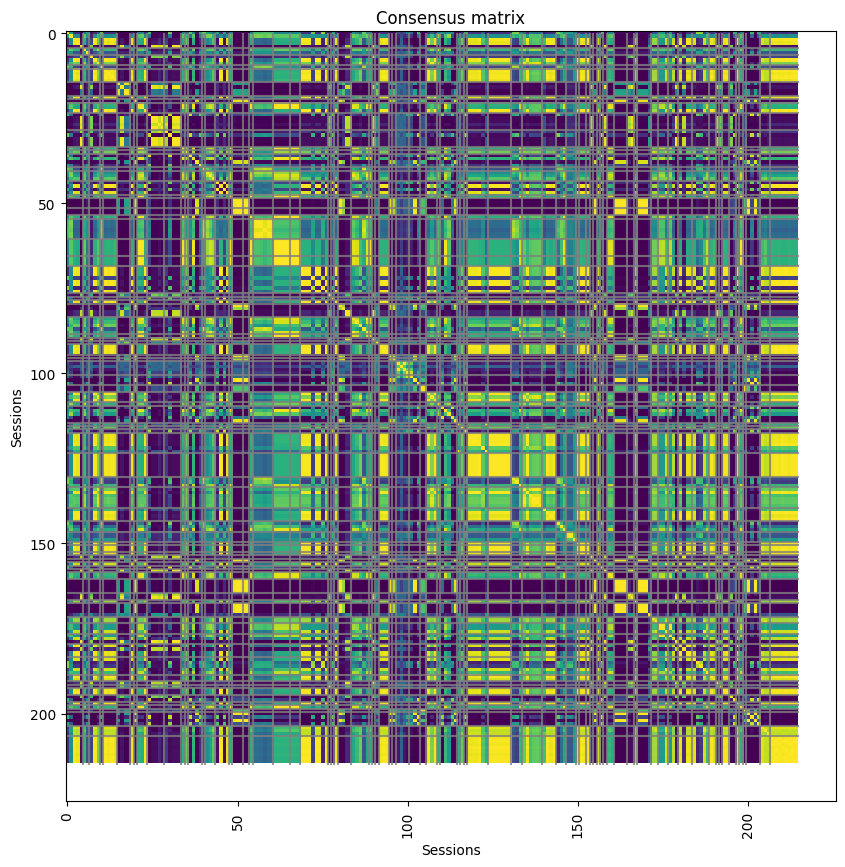

In [306]:
# plt.imshow(consensus_matrix)
# plt.xlabel('Sessions')
# plt.ylabel('Sessions')
# plt.title('Consensus matrix')

fig, ax = plt.subplots(figsize=[12, 10])
plt.imshow(consensus_matrix)
plt.xlabel('Sessions')
plt.ylabel('Sessions')
plt.title('Consensus matrix')

mouse_numbers = pd.factorize(session_syllables['mouse_name'])[0]
# mouse_numbers = session_mouse_names
for m_lines in np.where(np.diff(mouse_numbers)==1):
    plt.vlines(m_lines+.5, 0, len(mouse_numbers), color='grey', alpha=.8)
    plt.hlines(m_lines+.5, 0, len(mouse_numbers), color='grey', alpha=.8)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)


## Entropy

In [20]:
from scipy.stats import entropy

#def calculate_entropy(all_cluster_repeats):
mice = design_df['mouse_name'].unique()
mouse_numbers = pd.factorize(design_df['mouse_name'])[0]
cluster_entropy = pd.DataFrame(columns=['mouse_name', 'True', 'Shuffled', 'session_len'])

for m, mouse in enumerate(design_df['mouse_name'].unique()):
    # cluster_entropy['mouse_name'][m] = mouse

    mouse_repeats = pd.DataFrame(columns=['mouse_name', 'True', 'Shuffled', 'session_len'], index=range(repeats))
    
    agree = []
    shuffle_agree = []
    for r, rep in enumerate(range(repeats)):

        repeat_data = list(samplings_df.loc[samplings_df['repeat']==r, 'clusters'])[0]
        mouse_session_clusters = repeat_data[np.where(mouse_numbers==m)]
        if len(mouse_session_clusters) > 0:
        
            # repeat_data = mouse_session_parts.loc[mouse_session_parts['repeat']==r, 'y_kmeans']
            # Count cluster label occurrences for sample i
            labels, counts = np.unique(np.array(mouse_session_clusters), return_counts=True)
            prob = counts / counts.sum()
            ent = entropy(prob)  # Shannon entropy
            # same = 1 if np.array(repeat_data)[0] == np.array(repeat_data)[1] else 0
            # agree.append(same)
            agree.append(ent)

            # Test for random cluster assignment
            shuffle = np.random.randint(np.min(repeat_data), np.max(repeat_data), len(mouse_session_clusters))
            # same_shuffle = 1 if shuffle[0]==shuffle[1] else 0
            # shuffle_agree.append(same_shuffle)
            _, shuffle_counts = np.unique(shuffle, return_counts=True)
            shuff_prob = shuffle_counts / shuffle_counts.sum()
            shuff_ent = entropy(shuff_prob)  # Shannon entropy
            shuffle_agree.append(shuff_ent)
            
        mouse_repeats['mouse_name'][r] = mouse
        mouse_repeats['True'][r] = np.mean(agree)
        mouse_repeats['Shuffled'][r] = np.mean(shuffle_agree)
        mouse_repeats['session_len'][r] = len(mouse_session_clusters)
    
    cluster_entropy = pd.concat([cluster_entropy, mouse_repeats])
    
    # cluster_entropy['True'][m] = np.mean(agree)
    # cluster_entropy['Shuffled'][m] = np.mean(shuffle_agree)
    # cluster_entropy['session_len'][m] = len(mouse_session_clusters)

melted_df = pd.melt(cluster_entropy, id_vars=['mouse_name', 'session_len'], value_vars=['True', 'Shuffled'])

/tmp/ipykernel_25862/4021477868.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mouse_repeats['mouse_name'][r] = mouse
/tmp/ipykernel_25862/4021477868.py:40: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
Yo

In [80]:
cluster_entropy['dif'] = (cluster_entropy['True'] - cluster_entropy['Shuffled']) # /cluster_entropy['Shuffled']

<Axes: xlabel='variable', ylabel='value'>

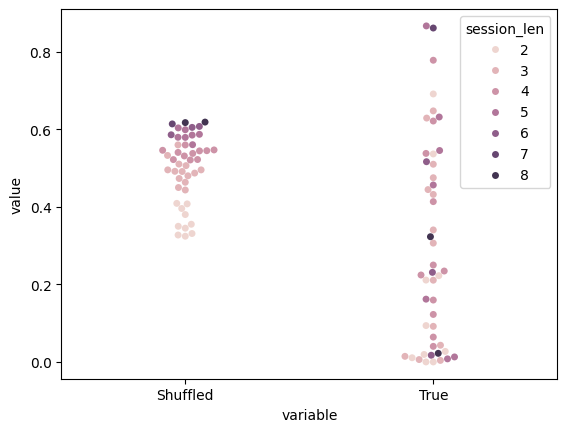

In [21]:
mice_mean_entropy = melted_df.groupby(['mouse_name', 'variable', 'session_len'])['value'].mean().reset_index()
sns.swarmplot(x='variable', y='value', data=mice_mean_entropy.loc[mice_mean_entropy['session_len']>1], alpha=0.9, hue='session_len')
# sns.boxplot(x='variable', y='value', data=mice_meac_entropy.loc[mice_meac_entropy['session_len']>1])
# sns.swarmplot(x='variable', y='value', data=melted_df.loc[melted_df['session_len']>1])

## Pairwise distance distributions

In [26]:
mice = design_df['mouse_name'].unique()

# samplings_df.loc[r, 'distance_matrix'] = pairwise_matrix
mouse_distance_df = pd.DataFrame(columns=['mouse_name', 'distance', 'random'], index =range(len(mice)))

for m, mouse in enumerate(mice):
    
    mouse_sessions = np.where(np.array(design_df['mouse_name'])==mouse)[0]
    random_sessions = np.random.choice(215, len(mouse_sessions))
    mouse_distances = np.zeros(repeats)*np.nan
    random_distances = np.zeros(repeats)*np.nan

    if len(mouse_sessions) > 1:
        for r in range(repeats):
            repeat_matrix = samplings_df.loc[r, 'distance_matrix']
            mouse_distances[r] = np.nanmean(repeat_matrix[np.ix_(mouse_sessions, mouse_sessions)])
            random_distances[r] = np.nanmean(repeat_matrix[np.ix_(random_sessions, random_sessions)])
        mouse_distance_df['distance'][m] = np.nanmean(mouse_distances)
        mouse_distance_df['random'][m] = np.nanmean(random_distances)

    else:
        mouse_distance_df['distance'][m] = np.nan
        mouse_distance_df['random'][m] = np.nan
    mouse_distance_df['mouse_name'][m] = mouse


/tmp/ipykernel_25862/4063649926.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mouse_distance_df['distance'][m] = np.nanmean(mouse_distances)
/tmp/ipykernel_25862/4063649926.py:19: FutureWarning: ChainedAssignmentError: behaviour will 

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'Cosine distance')

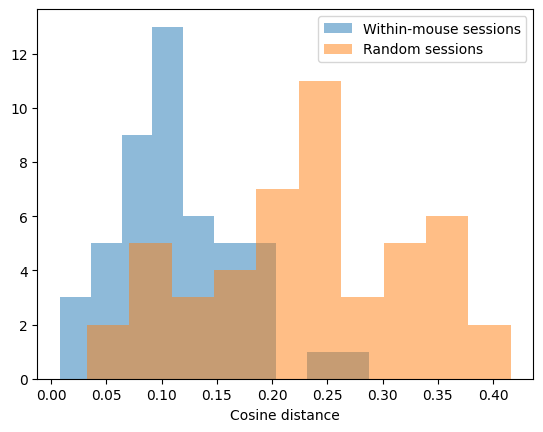

In [27]:
plt.hist(mouse_distance_df['distance'], alpha=0.5, label='Within-mouse sessions')
plt.hist(mouse_distance_df['random'], alpha=0.5, label='Random sessions')
plt.legend()
plt.xlabel('Cosine distance')

In [82]:
mean_entropy = cluster_entropy.groupby(['mouse_name', 'session_len'])['dif'].mean().reset_index()
joint_metrics = mouse_distance_df.merge(mean_entropy, on='mouse_name')

(0.42892770336290076, 0.0023509467157895028)


/tmp/ipykernel_25862/2478288014.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(X, y)[0]


(-0.0, 0.3)

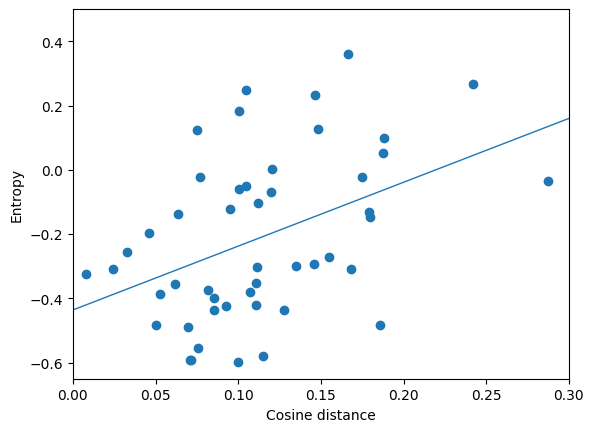

In [87]:
plt.scatter(joint_metrics['distance'], joint_metrics['dif'])
plt.xlabel('Cosine distance')
plt.ylabel('Entropy')
from scipy import stats
from sklearn.linear_model import LinearRegression
x = np.array(joint_metrics.loc[joint_metrics['session_len']>1, 'distance'].astype(float))
y = np.array(joint_metrics.loc[joint_metrics['session_len']>1, 'dif'].astype(float))
res = stats.pearsonr(x, y)
print(res)
X = np.vstack([x, np.ones(len(x))]).T
ols = LinearRegression(fit_intercept=True)
ols.fit(np.array(X), np.array(y))
m, c = np.linalg.lstsq(X, y)[0]

new_x = np.arange(0, 1, 0.01)
# new_X = np.vstack([new_x, np.ones(len(new_x))]).T
plt.plot(
    new_x,
    m* new_x + c,
    label="Linear Regression Model",
    linewidth=1,
)
plt.ylim([-.65, .5])
plt.xlim([-.0, .3])

## Clustering

In [307]:
final_clustering = AgglomerativeClustering(n_clusters=k, metric='cosine', linkage="average")
final_clusters = final_clustering.fit_predict(1 - consensus_matrix)  # Convert to similarity
# session_syllables['session_cluster'] = final_clusters 

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:566: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


(array([119.,   0.,   0.,  26.,   0.,   0.,  40.,   0.,   0.,  30.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

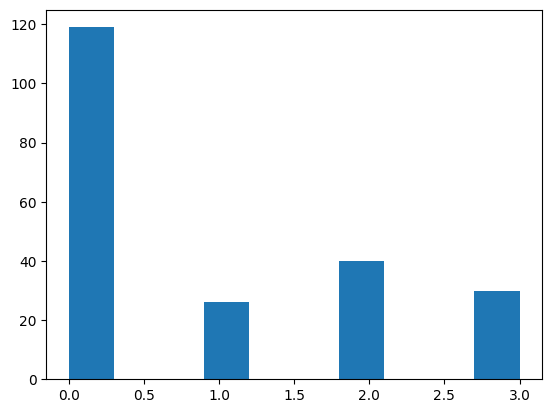

In [308]:
plt.hist(final_clusters)

array([[1.   , 0.63 , 0.6  , 0.775, 0.815, 0.635, 0.73 , 0.725, 0.735,
        0.755, 0.74 , 0.73 , 0.775, 0.845, 0.79 , 0.615, 0.795, 0.815,
        0.805, 0.71 , 0.625, 0.62 , 0.84 , 0.83 ],
       [0.63 , 1.   , 0.575, 0.73 , 0.765, 0.865, 0.86 , 0.865, 0.855,
        0.825, 0.86 , 0.86 , 0.605, 0.595, 0.79 , 0.895, 0.765, 0.705,
        0.61 , 0.78 , 0.54 , 0.535, 0.55 , 0.6  ],
       [0.6  , 0.575, 1.   , 0.63 , 0.595, 0.55 , 0.58 , 0.575, 0.585,
        0.58 , 0.59 , 0.58 , 0.585, 0.615, 0.6  , 0.555, 0.595, 0.59 ,
        0.61 , 0.59 , 0.595, 0.6  , 0.63 , 0.63 ],
       [0.775, 0.73 , 0.63 , 1.   , 0.88 , 0.7  , 0.825, 0.82 , 0.83 ,
        0.86 , 0.835, 0.825, 0.65 , 0.71 , 0.885, 0.695, 0.9  , 0.87 ,
        0.84 , 0.775, 0.58 , 0.575, 0.675, 0.665],
       [0.815, 0.765, 0.595, 0.88 , 1.   , 0.77 , 0.885, 0.88 , 0.89 ,
        0.93 , 0.895, 0.885, 0.66 , 0.72 , 0.975, 0.75 , 0.96 , 0.88 ,
        0.81 , 0.815, 0.59 , 0.585, 0.705, 0.715],
       [0.635, 0.865, 0.55 , 0.7  ,

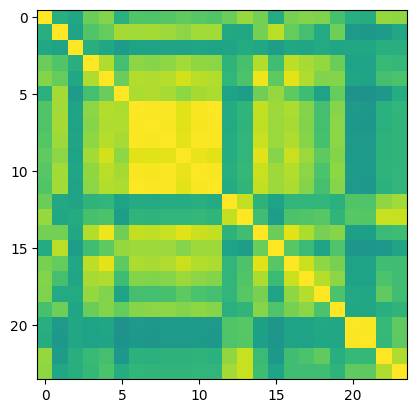

In [186]:
cluster_1 = np.where(final_clusters==2)[0]
plt.imshow(consensus_matrix[np.ix_(cluster_1, cluster_1)], vmin=0, vmax=1)
consensus_matrix[np.ix_(cluster_1, cluster_1)]

## Save

In [ ]:
file_to_save = design_df.droplevel(1, axis=1)[['mouse_name', 'session', 'session_cluster']].copy()
filename = "cluster_per_session_dendogram"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = '4.8_clustering_session_sequences_dendogram.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

In [265]:
new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session', 'session_cluster']]
filename = "cluster_per_session_dendogram"
new_df.to_parquet(filename)  

## Prepare design matrix

In [291]:
ori_X = consensus_matrix.copy()

print(np.shape(ori_X))

(215, 215)


## Pairwise cosyne distances

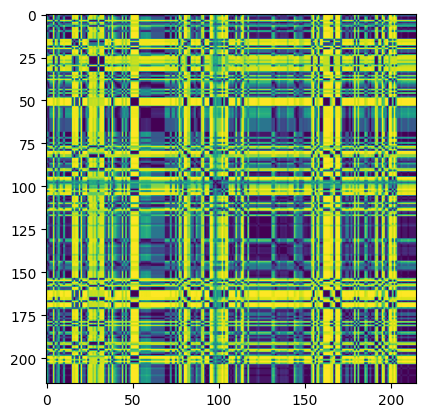

In [292]:
cos_dist = pairwise_distances(ori_X, metric='cosine')
plt.imshow(cos_dist)

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_4336/101162269.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method, metric='cosine')


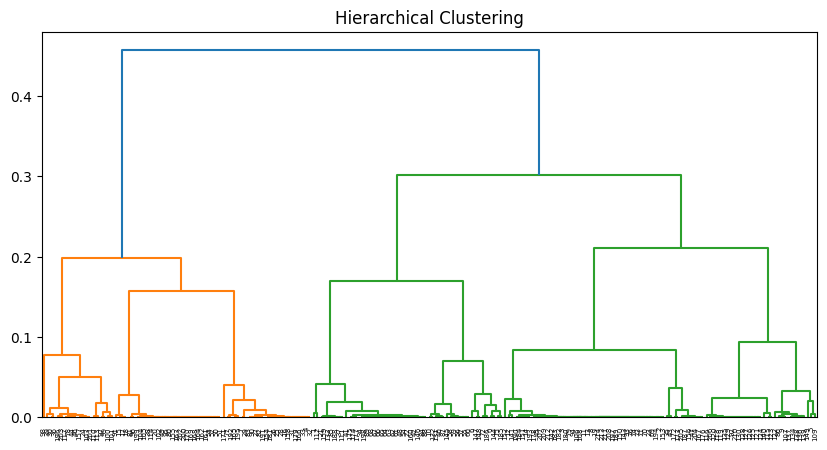

In [200]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine


def plot_dendrogram(distance_matrix, method, title="Hierarchical Clustering"):
    """
    Performs hierarchical clustering and plots a dendrogram.
    """
    linkage_matrix = sch.linkage(distance_matrix, method, metric='cosine')
    plt.figure(figsize=(10, 5))
    sch.dendrogram(linkage_matrix, leaf_rotation=90)
    plt.title(title)
    plt.show()
    return linkage_matrix
    
linkage_matrix = plot_dendrogram(cos_dist, 'complete', title="Hierarchical Clustering")

In [ ]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')
# session_syllables['session_cluster'] = clusters 

In [309]:
# Associate clusters with unsplit data; attention to sorting!!

use_sequences = all_sequences.copy()
use_df = use_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = use_df.keys()[-4:]
    
use_binarized = binarize(use_df)
full_session_syllables = pd.DataFrame(use_binarized)
full_session_syllables['session'] = use_df['session'].copy()
full_session_syllables['mouse_name'] = use_df['mouse_name'].copy()
full_session_syllables = full_session_syllables.groupby(['session', 'mouse_name'])[np.arange(0, 640, 1)].mean().reset_index()
full_session_syllables = full_session_syllables.sort_values(by='mouse_name')

full_session_syllables['session_cluster'] = final_clusters.copy()

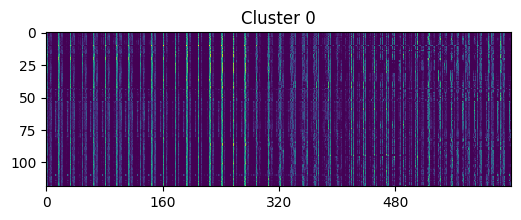

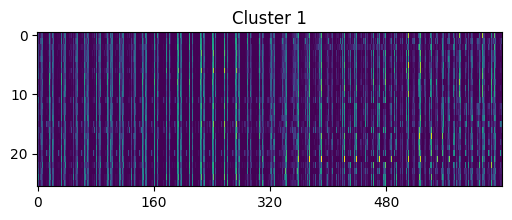

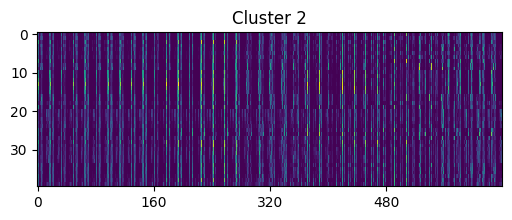

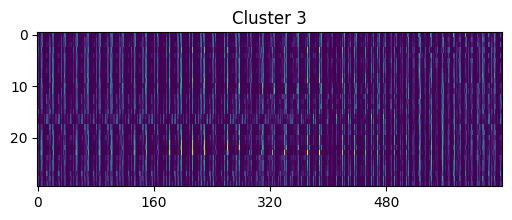

In [310]:
for c, cluster in enumerate(np.unique(final_clusters)):
    indices = np.where(final_clusters==cluster)[0]
    data = np.array(full_session_syllables[np.arange(0,640, 1)])[indices, :]
    plt.figure(figsize=(6, 2))
    plt.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))
    plt.title('Cluster ' + str(c))
    plt.show()

In [311]:
use_states = 16
timesteps = 40
reshaped_probs = pd.DataFrame()

for c, cluster in enumerate(np.unique(final_clusters)):
    reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob'], index=range(use_states * timesteps))
    indices = np.where(final_clusters==cluster)[0]
    syllable_prob = np.array(full_session_syllables[np.arange(0,640, 1)])[indices, :].mean(axis=0)
    for t in range(timesteps):
        reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '010', '110',
                '210', '310', '001', '101', '201', '301', '011',
                '111', '211', '311']
        reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
        reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
        reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
    
    # Save
    reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_4336/760161846.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '010', '110',
/va

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with 

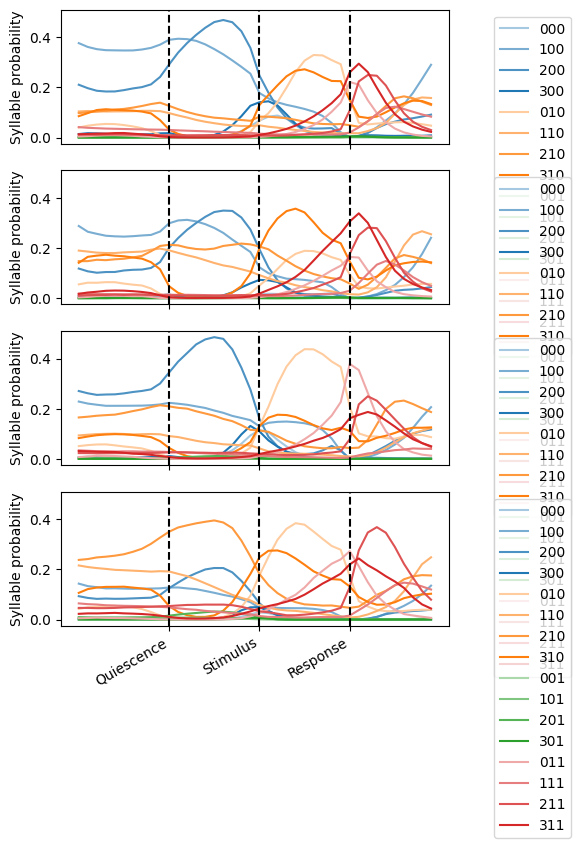

In [313]:
palette_16 = create_grouped_gradient_palette(n_groups=4, shades_per_group=4, base_palette='tab10')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
order = ['000', '100', '200', '300', '010', '110',
           '210', '310', '001', '101', '201', '301', '011',
           '111', '211', '311']
state_to_color = dict(zip(order, palette_16_list))

fig, axs = plt.subplots(k, 1, sharex=True, sharey=True, figsize=(5, 8))
for c, cluster in enumerate(np.unique(final_clusters)):
    sns.lineplot(x='timestep', y='prob', hue='syllable', data=reshaped_probs.loc[reshaped_probs['cluster']==cluster], 
                ax=axs[c], palette=palette_16_list)
    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')
    axs[c].set_ylabel('Syllable probability')
    axs[c].set_xlabel('')
    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))


In [222]:
file_to_save = new_df.copy()
filename = "cluster_per_session_dendogram"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = '4.8_clustering_session_sequences_dendogram.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

## Correlates of session clusters

In [140]:
data_path = prefix + 'representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')  
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

/tmp/ipykernel_8718/3499453394.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  learning_df = pd.read_csv(data_path+'learning_private_one.csv')


In [219]:
df = new_df.merge(learning_times, on='mouse_name')

In [220]:
data_path =  prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

a = df[['mouse_name', 'training_time']].merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()

full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

/tmp/ipykernel_8718/1478564848.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))


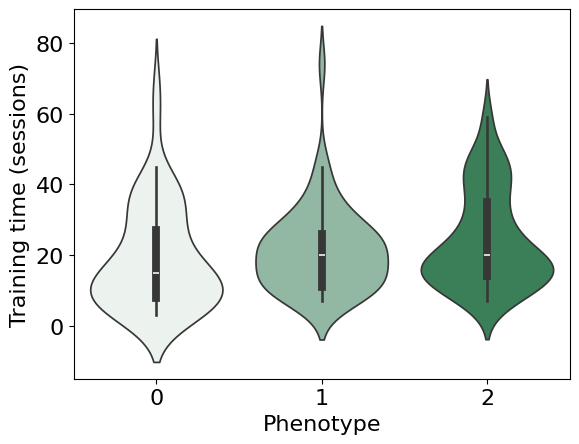

P-value for KW: 0.020
          1         2        3
1  1.000000  0.313108  0.01586
2  0.313108  1.000000  1.00000
3  0.015860  1.000000  1.00000


In [223]:
# --Machine learning and statistics
from scipy.stats import ttest_ind
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

var_1 = 'training_time ~ session_cluster'
var = 'training_time'
# var = 'elongation'
# var_1 = 'elongation ~ part_cluster'
# Define the model using ordinary least squares (OLS) and fit it
data = df.dropna()
# data = df.loc[df['mouse_name'].isin(filter_mice)].dropna()
# data = pd.DataFrame(df.groupby(['mouse_name', 'part_cluster'])[var].mean()).reset_index().dropna()

model = ols(var_1, data=data).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

# print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=data[var], groups=data['session_cluster'], alpha=0.05)
# print(tukey)

plt.rcParams.update({'font.size': 16})
sns.violinplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.barplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.scatterplot(x='part_cluster', y=var, data=data, color='black')
plt.xticks([0, 1, 2], [0, 1, 2])
# plt.ylim([0, 80])
plt.xlabel('Phenotype')
plt.ylabel('Proportion correct')
plt.ylabel('Training time (sessions)')
plt.show()

group_1 = df.loc[df['session_cluster']==1, var]
group_2 = df.loc[df['session_cluster']==2, var]
group_3 = df.loc[df['session_cluster']==3, var]
# group_4 = df.loc[df['session_cluster']==4, var]


stat, p_value = stats.kruskal(group_1, group_2, group_3)
# stat, p_value = stats.kruskal(group_1, group_2)

print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(df.dropna(), val_col=var, group_col='session_cluster', p_adjust='bonferroni')
print(posthoc)